In [12]:
# Code aus "Neuronale Netze selbst programmieren,
# ein verständlicher Einstieg mit Python"
# von Tariq Rashid , O'Reilly
# license GPLv2
import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
import matplotlib.pyplot
%matplotlib inline
import os
# helper to load data from PNG image files
import imageio
# glob helps select multiple files using patterns
import glob
import pickle
import logging
logging.basicConfig(filename='/home/ubuntu/Documents/Code/CatDog-Python/CatDog-Python/logfile.txt', level=logging.DEBUG)

In [22]:
# neural network class definition
class neuralNetwork:


    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        try:# set number of nodes in each inpzt, hidden oputput layer
            self.inodes = inputnodes + 2
            self.hnodes = hiddennodes
            self.onodes = outputnodes

            # learning rate
            self.lr = learningrate

            # link weight matrices, wih and who 
            # weights inside the arrays aer w_i_j, where link is from node i to node j in the next layer
            self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
            self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))

            try:
                # acitivation function is the sigmoid funciton
                self.activation_function = lambda x: x*x
                self.inverse_activation_function = lambda x: scipy.special.logit(x)
            except:
                logging.error("An error occured: activation function failed")

            pass
        except:
            logging.error("An error occured: initialization failed")


    # train the neural network
    def train(self, inputs_list, targets_list):
        try:
            # convert inputs list to 2d array
            inputs = numpy.array(inputs_list, ndmin=2).T
            targets = numpy.array(targets_list, ndmin=2).T

            # calculate signals into hidden layer
            hidden_inputs = numpy.dot(self.wih, inputs)
            # calculate the signals emerging from hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)

            # calculate signals into final output layer
            final_inputs = numpy.dot(self.who, hidden_outputs)
            # calculate the signals emerging from final output layer
            final_outputs = self.activation_function(final_inputs)

            # output layer error is the (target - actual)
            output_errors = targets - final_outputs
            # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
            hidden_errors = numpy.dot(self.who.T, output_errors)

            # update the weights for the links between the hidden and output layers
            self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

            # update the weights for the links between the input and hidden layers
            self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

            pass
        except:
            print("MOOOIN Meister")
            logging.error("An error occured: training failed")
    try:
        # query the neural network
        def query(self, inputs_list):
            # convert inputs list to 2d array
            inputs = numpy.array(inputs_list, ndmin=2).T
            
            # calculate signals into hidden layer        
            hidden_inputs = numpy.dot(self.wih, inputs)
            # calculate the signals emerging from hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)      
            
            # calculate signals final output layer        
            final_inputs = numpy.dot(self.who, hidden_outputs)
            # calculate the signals emerging final output layer
            final_outputs = self.activation_function(final_inputs)
            
            return final_outputs
    except:
        logging.error("An error occured: query failed")

    try:    
        # backquery the neural network
        # we'll use the same termnimology to each item, 
        # eg target are the values at the right of the network, albeit used as input
        # eg hidden_output is the signal to the right of the middle nodes
        def backquery(self, targets_list):
            # transpose the targets list to a vertical array
            final_outputs = numpy.array(targets_list, ndmin=2).T
            
            # calculate the signal into the final output layer
            final_inputs = self.inverse_activation_function(final_outputs)

            # calculate the signal out of the hidden layer
            hidden_outputs = numpy.dot(self.who.T, final_inputs)
            # scale them back to 0.01 to .99
            hidden_outputs -= numpy.min(hidden_outputs)
            hidden_outputs /= numpy.max(hidden_outputs)
            hidden_outputs *= 0.98
            hidden_outputs += 0.01
            
            # calculate the signal into the hidden layer
            hidden_inputs = self.inverse_activation_function(hidden_outputs)
            
            # calculate the signal out of the input layer
            inputs = numpy.dot(self.wih.T, hidden_inputs)
            # scale them back to 0.01 to .99
            inputs -= numpy.min(inputs)
            inputs /= numpy.max(inputs)
            inputs *= 0.98
            inputs += 0.01
            
            return inputs
    except:
        logging.error("An error occured: backquery failed")

In [23]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.6

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [24]:
# https://stackoverflow.com/questions/7165749/open-file-in-a-relative-location-in-python
# relative path to files
fileDir = os.path.dirname(os.path.realpath('__file__'))
# For accessing the file in the parent folder of the current folder
# small test data for quick calculations
#training_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_train_100.csv')
#test_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_test_10.csv')
# real test data (60'000 training data / 10'000 test data)
training_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_train.csv')
test_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_test.csv') 
test_data_png = os.path.join(fileDir, '../../trainingdata/testdata_mnist/2828_my_own_?.png') 

In [25]:
# load mnist training csv file into a list
training_data_file = open(training_data_path, 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [26]:
# train the neural network
# epochs is the number of times the training data set is used for training
epochs = 1

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale input to range 0.01 to 1.00
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Meister
MOOOIN Mei

KeyboardInterrupt: 

In [18]:
# load mnist test csv file into a list
test_data_file = open(test_data_path, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [19]:
#get the first test record
all_values = test_data_list[1].split(',')
# print the label
print(all_values[0]) 

2


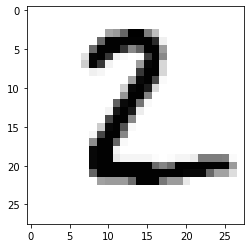

In [20]:
image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [21]:
n.query((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)

ValueError: shapes (200,786) and (784,1) not aligned: 786 (dim 1) != 784 (dim 0)

In [ ]:
# test the neural network
# scorecard for how well the network performs
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale input to range 0.01 to 1.00
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass

In [ ]:
# calculate the performance score (correct answers/ all answers)
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

In [ ]:
# our own image test data set
our_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob(test_data_png):
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data  = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data  to test data set
    record = numpy.append(label,img_data)
    our_own_dataset.append(record)
    
    pass

In [ ]:
# test the neural network with our own images

# record to test
item = 0

# plot image
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass

In [ ]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 5
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

In [ ]:
trained_Number_NN_Path = os.path.join(fileDir, 'Trained_NN/Numbers/numberNN*.nn') 
numberNeuralNetworkList = []
print("getAllNN search path: ",trained_Number_NN_Path)
# for every numberNN file in the folder
for trained_NN_Path in glob.glob(trained_Number_NN_Path):
    print("getAllNN current path: ",trained_NN_Path)
    # open the file and save the object 
    with open(trained_NN_Path, 'rb') as input:
        # read the nn
        readNN = pickle.load(input)
        # append it to the list of NNs
        numberNeuralNetworkList.append(readNN)

print("numberNN: ",numberNeuralNetworkList)